# Imports

In [1]:
import librosa
import os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import scale
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import io

2025-05-06 08:50:08.748471: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load MFCC Preprocessed MFCC Images

In [9]:
#Function for getting x and y data for a specific kind of dataset
#For example, pass in addresses for training csv and mfcc images to get X_train and y_train
def load_images_from_csv(csv_path, image_dir):
    #Get values from csv
    df = pd.read_csv(csv_path)

    #For csv, create a new column that has the full path to images
    df['filepath'] = df['File'].apply(lambda fname: os.path.join(image_dir, fname.replace('.wav', '.png')))

    label_map = {'genuine': 0, 'spoof': 1}
    #Create arrays with the addresses and another one with the labels
    labels = df['Label'].map(label_map)
    images = []
    for path in df['filepath']:
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)  # or 1 for grayscale
        img = tf.image.convert_image_dtype(img, tf.float32)  # [0.0, 1.0]
        images.append(img.numpy())
        
    return np.array(images), np.array(labels)     
   

In [10]:
X_train, y_train = load_images_from_csv(
    '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_train.csv',
    '/home/enriq115/dev/research/cs478/FinalProject/Dataset/MFCC/ASVspoof2017_V2_train'
)

X_test, y_test = load_images_from_csv(
    '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_eval.csv',
    '/home/enriq115/dev/research/cs478/FinalProject/Dataset/MFCC/ASVspoof2017_V2_eval'
)

X_val, y_val = load_images_from_csv(
    '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_dev.csv',
    '/home/enriq115/dev/research/cs478/FinalProject/Dataset/MFCC/ASVspoof2017_V2_dev'
)

# Load Preprocessed Spectrogram Images 

In [2]:
spect_eval_path = '/home/enriq115/dev/research/cs478/FinalProject/spectrogram_images_output/testing'
spect_train_path = '/home/enriq115/dev/research/cs478/FinalProject/spectrogram_images_output/training'
spect_dev_path = '/home/enriq115/dev/research/cs478/FinalProject/spectrogram_images_output/validation'

In [3]:
def load_images_from_folder(folder, label, target_size=(200, 200)):
    images = []
    labels = []
    
    # Loop through each file in the folder
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        image = Image.open(filepath)
        image = image.convert('RGB')
        
        # high-quality downsampling
        image = image.resize(target_size, Image.LANCZOS)
        images.append(np.array(image))
        labels.append(label)
    return images, labels

# Initialize lists for train, validation, and test sets
X_train, y_train = [], []
X_val,   y_val   = [], []
X_test,  y_test  = [], []

# Process the training data
for class_name in ['genuine', 'spoof']:
    class_folder = os.path.join(spect_train_path, class_name)
    label = 0 if class_name == 'genuine' else 1
    imgs, labels = load_images_from_folder(class_folder, label)
    X_train.extend(imgs)
    y_train.extend(labels)
    
# Process the validation data
for class_name in ['genuine', 'spoof']:
    class_folder = os.path.join(spect_dev_path, class_name)
    label = 0 if class_name == 'genuine' else 1
    imgs, labels = load_images_from_folder(class_folder, label)
    X_val.extend(imgs)
    y_val.extend(labels)

# Process the test data
for class_name in ['genuine', 'spoof']:
    class_folder = os.path.join(spect_eval_path, class_name)
    label = 0 if class_name == 'genuine' else 1
    imgs, labels = load_images_from_folder(class_folder, label)
    X_test.extend(imgs)
    y_test.extend(labels)

# Convert lists to numpy arrays
X_train = np.array(X_train, dtype='float32') / 255.0
y_train = np.array(y_train)
X_val   = np.array(X_val,   dtype='float32') / 255.0
y_val   = np.array(y_val)
X_test  = np.array(X_test,  dtype='float32') / 255.0
y_test  = np.array(y_test)

# Print shapes
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

# Print class counts for each split
for split_name, labels in [
    ('Training', y_train),
    ('Validation', y_val),
    ('Test', y_test)
]:
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{split_name} set class distribution:")
    for cls, cnt in zip(unique, counts):
        name = 'Real' if cls == 0 else 'Fake'
        print(f"  {name}: {cnt}")

Training set: (3014, 200, 200, 3)
Validation set: (1710, 200, 200, 3)
Test set: (13306, 200, 200, 3)

Training set class distribution:
  Real: 1507
  Fake: 1507

Validation set class distribution:
  Real: 760
  Fake: 950

Test set class distribution:
  Real: 1298
  Fake: 12008


In [4]:
y_train[1500:1515]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

# CNN Model (as accurate as possible)

In [5]:
def create_model():
    K.clear_session()
    tf.random.set_seed(42) 
    model = models.Sequential()

    #Input Spectrogram/MFCC
    model.add(layers.InputLayer(input_shape=(200,200,3)))
    
    #First 2D Conv Layer and 2d Max Pooling
    model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    #Second 2d Conv layer followed by Global Max Pooling
    model.add(layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu'))
    model.add(layers.GlobalMaxPooling2D()) 

    # Fully connected layer for classification
    model.add(layers.Dense(1, activation='sigmoid')) 

    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    model.summary()
    return model

In [15]:
model = create_model()

model.fit(
    X_train, 
    y_train,    
    epochs=30,
    steps_per_epoch=8,
    validation_data = (X_val, y_val),
)

/home/enriq115/miniconda3/envs/my_env/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 8)              │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,617 (6.32 KB)

 Trainable params: 1,617 (6.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5067 - loss: 0.7386 - val_accuracy: 0.5561 - val_loss: 0.6869
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 943ms/step - accuracy: 0.4900 - loss: 0.7005 - val_accuracy: 0.5556 - val_loss: 0.6883
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 960ms/step - accuracy: 0.4792 - loss: 0.6960 - val_accuracy: 0.4444 - val_loss: 0.6962
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 957ms/step - accuracy: 0.5100 - loss: 0.6927 - val_accuracy: 0.4444 - val_loss: 0.6959
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 949ms/step - accuracy: 0.5279 - loss: 0.6905 - val_accuracy: 0.5643 - val_loss: 0.6913
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 961ms/step - accuracy: 0.6232 - loss: 0.6894 - val_accuracy: 0.5632 - val_loss: 0.6913
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 944ms/step - accuracy: 0.6369 - loss: 0.6872 - val_accuracy: 0.5415 - val_loss: 0.6916
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 954ms/step - accuracy: 0.6647 - loss: 0.6852 - val_accuracy: 0.5743 - val_loss: 0.

# Predict on data

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

=== Classification Report — Train ===
              precision    recall  f1-score   support

     Genuine       0.77      0.61      0.68      1507
       Spoof       0.68      0.82      0.74      1507

    accuracy                           0.71      3014
   macro avg       0.72      0.71      0.71      3014
weighted avg       0.72      0.71      0.71      3014



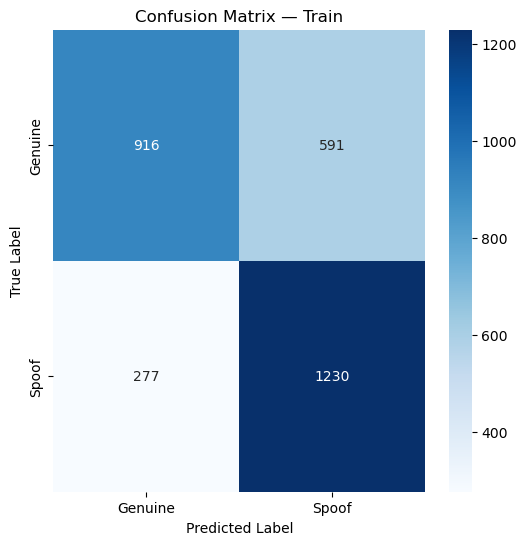


=== Classification Report — Validation ===
              precision    recall  f1-score   support

     Genuine       0.57      0.30      0.39       760
       Spoof       0.59      0.82      0.69       950

    accuracy                           0.59      1710
   macro avg       0.58      0.56      0.54      1710
weighted avg       0.58      0.59      0.56      1710



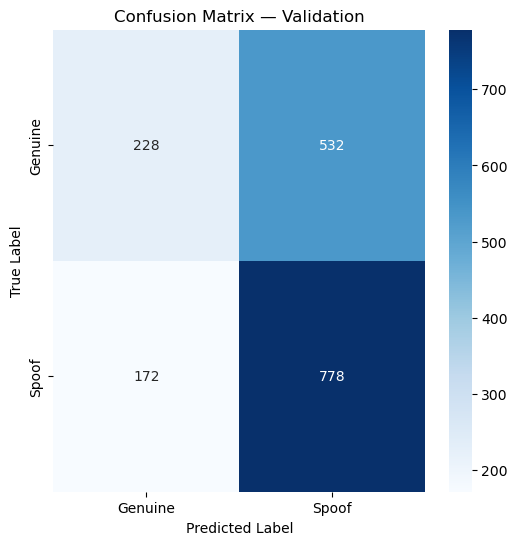


=== Classification Report — Test ===
              precision    recall  f1-score   support

     Genuine       0.13      0.40      0.20      1298
       Spoof       0.92      0.72      0.80     12008

    accuracy                           0.69     13306
   macro avg       0.52      0.56      0.50     13306
weighted avg       0.84      0.69      0.75     13306



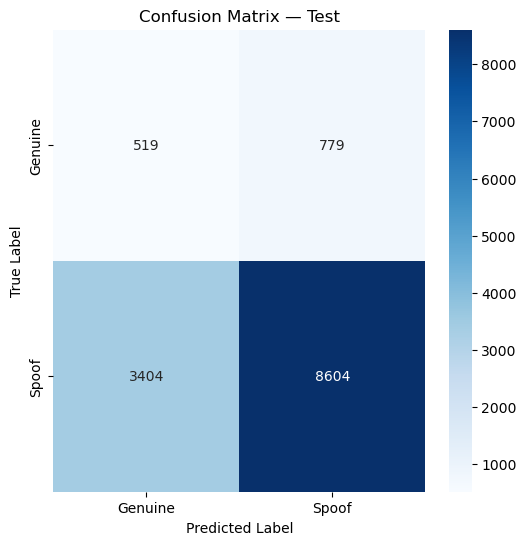

In [16]:
y_pred_train_raw = model.predict(X_train)
y_pred_val_raw   = model.predict(X_val)
y_pred_test_raw  = model.predict(X_test)

def to_labels(probs):
    if probs.ndim > 1 and probs.shape[1] > 1:
        return probs.argmax(axis=1)
    # threshold at 0.5
    return (probs > 0.5).astype(int).ravel()

y_pred_train = to_labels(y_pred_train_raw)
y_pred_val   = to_labels(y_pred_val_raw)
y_pred_test  = to_labels(y_pred_test_raw)

# Define class names
target_names = ['Genuine', 'Spoof']
 
#loop through each split
for split_name, y_true, y_pred in [
    ('Train',      y_train, y_pred_train),
    ('Validation', y_val,   y_pred_val),
    ('Test',       y_test,  y_pred_test)
]:
    print(f"\n=== Classification Report — {split_name} ===")
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix — {split_name}')
    plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Flatten if needed
y_test_flat = y_test.ravel()
y_pred_probs_flat = y_pred.ravel()

# Get FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred_probs_flat)

# Area Under Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
